In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import spacy 
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,  PCA, NMF
import random 

In [ ]:
df = pd.read_csv('/kaggle/input/covid19-public-media-dataset/covid19_articles_20200512.csv',index_col='Unnamed: 0')

df2 = pd.read_csv('/kaggle/input/covid19-public-media-dataset/covid19_articles_20200526.csv',index_col='Unnamed: 0')
df2.head()

df3 = pd.read_csv('/kaggle/input/covid19-public-media-dataset/covid19_articles_20200504.csv',index_col='Unnamed: 0')
df3.head()

# concatenating sources 
df = pd.concat([df,df2,df3],ignore_index=True)
df.head()

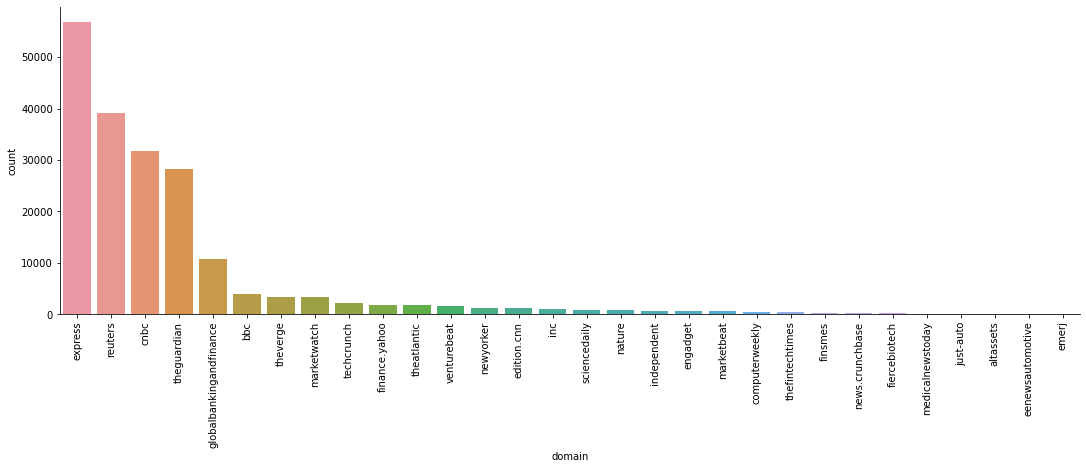

In [25]:
# visualize sources and their counts 
order_by = df['domain'].value_counts().index
sns.catplot(data=df,x='domain',kind='count',aspect=3,order=order_by)
plt.xticks(rotation=90)
plt.show()

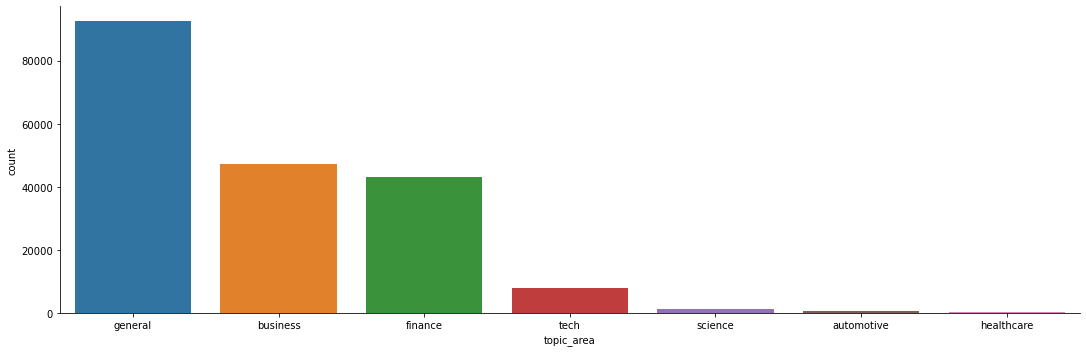

In [26]:
# topic areas
# here we can see 7 topic_areas, where general category is in majority 
order_by = df['topic_area'].value_counts().index
sns.catplot(kind='count',x='topic_area',aspect=3,data=df,order=order_by)
plt.show()

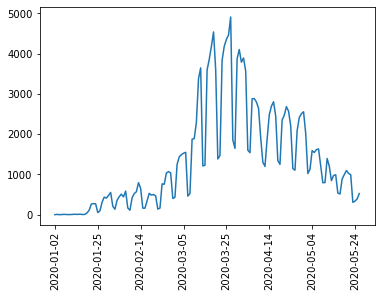

In [27]:
# dates aggregation 
df.date.value_counts().sort_index().plot()
plt.xticks(rotation=90)
plt.show()

In [11]:
nlp = spacy.load('en_core_web_sm',disable=['parser','ner','tokenizer'])

In [12]:
# from https://www.kaggle.com/jannalipenkova/covid-19-media-overview
RELEVANT_POS_TAGS = ["PROPN", "VERB", "NOUN", "ADJ"]

CUSTOM_STOPWORDS = ["say", "%", "will", "new", "would", "could", "other", 
                    "tell", "see", "make", "-", "go", "come", "can", "do", 
                    "such", "give", "should", "must", "use"]


In [13]:
# Data Preprocessing 
def preprocess(txt):
  '''
  Take text pass through spacy's pipeline 
  Normalize text using remove stopwords from CUSTOM_STOPWORDS, take words which are RELEVENT_POS_TAGS and
  take lemma and use that in smaller version of alphabet
  '''
  doc = nlp(txt)
  rel_tokens = " ".join([tok.lemma_.lower() for tok in doc if tok.pos_ in RELEVANT_POS_TAGS and tok.lemma_.lower() not in CUSTOM_STOPWORDS])
  return rel_tokens

In [14]:
tqdm.pandas()
processed_content = df["content"].progress_apply(preprocess)
df["processed_content"] = processed_content

100%|██████████| 192904/192904 [1:29:12<00:00, 36.04it/s]  


# Latent Dirichlet Allocation
LDA performs clustering inside, and is topic modeling technique.
It assumes that similar topics shares similar group of words or vocab.

In [21]:
cv = CountVectorizer(max_features=2**11,min_df=10,stop_words='english') # count vectorizer

In [22]:
dtm = cv.fit_transform(df['processed_content'])

In [23]:
LDA = LatentDirichletAllocation(n_components=7,random_state=42,n_jobs=-1) # LDA topic Modeling Technique

In [33]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=7, n_jobs=-1, random_state=42)

In [34]:
# get the vocabulary length of words 
len(cv.get_feature_names())

2048

In [35]:
# get some random words 
random_word_id = random.randint(0,2048)
cv.get_feature_names()[10]

'accurate'

In [36]:
# get the topics 
LDA.components_

array([[1.11439404e+04, 1.57275632e+03, 1.06828000e+04, ...,
        1.69620522e+02, 7.51831361e+02, 9.87415347e+01],
       [2.54671606e+03, 8.15751588e+02, 4.36520490e+03, ...,
        2.70099959e+02, 2.65833931e+02, 2.93176679e+00],
       [4.26377798e+04, 7.47979314e+02, 7.72480514e+03, ...,
        5.37068429e+03, 1.85059839e+03, 1.43593505e-01],
       ...,
       [1.23142612e+04, 1.04689340e+03, 1.47983930e+04, ...,
        4.07356068e+02, 3.89518561e+02, 4.62626192e+03],
       [3.30171727e+04, 1.48205579e+04, 5.53195888e+03, ...,
        1.74239561e+02, 2.79848456e+02, 5.52790801e+03],
       [8.58961312e+04, 4.02583874e+03, 7.55563713e+03, ...,
        5.65529557e+01, 3.84164141e+02, 5.83420819e+01]])

In [37]:
LDA.components_.shape

(7, 2048)

In [38]:
single_topic = LDA.components_[0]

In [39]:
# get the last 10 values which has high prob
top_ten_words = single_topic.argsort()[-10:]

In [40]:
# from here we can see, that words like "Pay, company, coronavirus, worker " are related to business 
for index in top_ten_words:
    print(cv.get_feature_names()[index])

people
support
work
need
state
pay
crisis
coronavirus
business
government


In [41]:
# get the highest probability words per topic 
for i,topic in enumerate(LDA.components_):
    print(f'The top 25 words for topic #{i}')
    print([cv.get_feature_names()[index] for index in topic.argsort()[-25:]])
    print('\n\n')

# Here we can check topic#1 related to financial, topic # 3 relates to tech, 

The top 25 words for topic #0
['small', 'payment', 'bank', 'month', 'year', 'money', 'time', 'loan', 'job', 'eu', 'pandemic', 'week', 'help', 'uk', 'worker', 'people', 'support', 'work', 'need', 'state', 'pay', 'crisis', 'coronavirus', 'business', 'government']



The top 25 words for topic #1
['win', 'old', 'liverpool', 'fan', 'event', 'want', 'world', 'transfer', 'sport', 'think', 'football', 'summer', 'time', 'premier', 'coronavirus', 'newspaper', 'year', 'team', 'united', 'play', 'game', 'club', 'player', 'league', 'season']



The top 25 words for topic #2
['state', 'hospital', 'measure', 'uk', 'confirm', 'lockdown', 'outbreak', 'minister', 'spread', 'china', 'home', 'travel', 'test', 'report', 'week', 'day', 'number', 'virus', 'death', 'government', 'health', 'country', 'people', 'case', 'coronavirus']



The top 25 words for topic #3
['outbreak', 'investor', 'expect', 'demand', 'rise', 'high', 'reuters', 'rate', 'month', 'economic', 'cut', 'report', 'global', 'low', 'bank', 'wee

In [42]:
topic_results = LDA.transform(dtm)

In [43]:
df['Topic'] = topic_results.argmax(axis=1)

# Non-Negative Matrix Factorization
NMF with clustering also performs dimensionality reduction

In [45]:
tfidf = TfidfVectorizer(max_features=2**11,min_df=10, stop_words='english')

In [46]:
dtm = tfidf.fit_transform(df['processed_content'])

In [47]:
nmf_model  = NMF(n_components=7,random_state=42)

In [48]:
nmf_model.fit(dtm)

NMF(n_components=7, random_state=42)

In [49]:
tfidf.get_feature_names()[1480]

'regulatory'

In [50]:
for i,topic in enumerate(nmf_model.components_):
    print(f'The top 25 words for topic #{i}')
    print([tfidf.get_feature_names()[index] for index in topic.argsort()[-25:]])

The top 25 words for topic #0
['rule', 'public', 'school', 'week', 'crisis', 'britain', 'need', 'worker', 'work', 'home', 'newspaper', 'country', 'coronavirus', 'boris', 'measure', 'nhs', 'eu', 'prime', 'people', 'lockdown', 'johnson', 'mr', 'minister', 'government', 'uk']
The top 25 words for topic #1
['analyst', 'gain', 'trade', 'demand', 'quarter', 'barrel', 'crude', 'rise', 'economic', 'global', 'rate', 'dollar', 'year', 'china', 'investor', 'cut', 'index', 'economy', 'low', 'fall', 'bank', 'stock', 'price', 'oil', 'market']
The top 25 words for topic #2
['sport', 'sign', 'match', 'solskjaer', 'old', 'sancho', 'newspaper', 'man', 'team', 'utd', 'manchester', 'arsenal', 'summer', 'game', 'play', 'chelsea', 'united', 'football', 'liverpool', 'transfer', 'premier', 'season', 'player', 'club', 'league']
The top 25 words for topic #3
['industry', 'technology', 'impact', 'share', 'year', 'financial', 'revenue', 'quarter', 'provide', 'work', 'store', '19', 'covid', 'sale', 'service', 'inf

In [ ]:
#  Here we can see that 
# nmfNumeric_to_topic = {0:'',1:'finance',2:'',3:'business',4:'healthcare',5:'',6:''}
#it depends on how we infer topics

In [51]:
topic_results = nmf_model.transform(dtm)

In [52]:
df['NMF_Topic'] = topic_results.argmax(axis=-1)

In [53]:
df.head()

,title,author,date,domain,url,content,topic_area,crawled_time,processed_content,Topic,NMF_Topic
0,My experience of surviving cancer twice,Helen Ziatyk,2020-01-03,medicalnewstoday,https://www.medicalnewstoday.com/articles/327373,"“Helen, I’m so sorry to tell you that you have...",healthcare,NaN,helen be sorry stage ovarian cancer forget hea...,4,5
1,Ginger: Health benefits and dietary tips,Jenna Fletcher,2020-01-03,medicalnewstoday,https://www.medicalnewstoday.com/articles/2659...,If you buy something through a link on this pa...,healthcare,NaN,buy link page may earn small commission work p...,6,3
2,China pneumonia outbreak may be caused by Sars...,Reuters,2020-01-08,theguardian,https://www.theguardian.com/science/2020/jan/0...,A cluster of more than 50 pneumonia cases in t...,general,NaN,cluster more pneumonia case central chinese ci...,6,4
3,New virus identified as likely cause of myster...,nature,2020-01-08,nature,https://www.nature.com/articles/d41586-020-000...,Passengers arriving at Hong Kong's internation...,science,NaN,passenger arrive hong kong international airpo...,6,4
4,China's Sars-like illness worries health exper...,https://www.theguardian.com/profile/sarahboseley,2020-01-09,theguardian,https://www.theguardian.com/world/2020/jan/09/...,The finding that the outbreak of viral pneumon...,general,NaN,finding outbreak viral pneumonia china strike ...,6,4
